## Notebook to compare Apollo's parameters for the ReLU Plus X toy model with embedding

## *reluPlusX_res_embed*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x \\
h = ReLU(W_1 e) \\
u = W_2 h + x
y' = W_u u
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [1]:
"""Notebook settings and imports."""

#%load_ext autoreload
#%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response

In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

In [3]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [4]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses



In [5]:
learning_rates = np.logspace(-5, 0, num=10)

In [8]:
"""Create and train model. - Apollo's learning rate"""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

# for training model
batch_sz = 1024
feat_sparsity = 0.99
feat_importance = 1
n_steps = 5000
logging_freq = n_steps // 10

# for testing over sparsities
sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
loss_data = []  # will store mean loss data

for lr in learning_rates: 
    
    reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)
     
    optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters(), lr=lr)
    
    losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )
    display(losses)

    """Get loss at inference over varying sparsity levels."""
    
    
    pbar = tqdm(sparsities, desc="Testing over sparsities")
    n_examples = 200
    loss_data_reluPlusEmbedv1 = []
    for s in pbar:
        
        with t.no_grad():
            # generate examples of inputs
            x, y_true = gen_batch(reluPlusX_res_embed_cis, n_examples, s)
            
            # compute mean loss
            y = reluPlusX_res_embed_cis.forward(x)
            active_weight, inactive_weight = 10, 1
            weights = t.where(y_true == 1, active_weight, inactive_weight)
            loss = weights * (y - y_true) ** 2
            
            # store loss at sparsity level
            loss = rearrange(loss, "examples 1 features -> examples features")
            loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
            for feat_idx, val in enumerate(loss):
                loss_data.append({"learning_rate": lr, "sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.002172069391235709,
 0.0020475592464208603,
 0.0019622445106506348,
 0.0016149731818586588,
 0.0017450484447181225,
 0.0015183095820248127,
 0.0015201717615127563,
 0.0015594270080327988,
 0.0013413075357675552,
 0.0012931200908496976,
 0.0011366461403667927]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.002038808772340417,
 0.0016318605048581958,
 0.0012468186905607581,
 0.0011276400182396173,
 0.001018658047541976,
 0.0008256332366727293,
 0.000808568496722728,
 0.000844762020278722,
 0.000716035661753267,
 0.0007311184308491647,
 0.0008127174223773181]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.001963310409337282,
 0.0009898931020870805,
 0.0008413728792220354,
 0.0007261597202159464,
 0.0007350648520514369,
 0.0007554631447419524,
 0.0006790763000026345,
 0.0007300811121240258,
 0.0007224543369375169,
 0.0007686802418902516,
 0.0006725129205733538]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.001797743490897119,
 0.0007524443790316582,
 0.0007211955962702632,
 0.0006784501601941884,
 0.0006992729031480849,
 0.0007387830992229283,
 0.0006585633382201195,
 0.0006920607993379235,
 0.000672730035148561,
 0.0007085739052854478,
 0.0007003229693509638]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.002002954250201583,
 0.0006303339032456279,
 0.000747737183701247,
 0.0007111922022886574,
 0.0006797301466576755,
 0.0006696864147670567,
 0.000649449008051306,
 0.0006951466202735901,
 0.0006896767881698906,
 0.0006959008751437068,
 0.0007111175800673664]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.002013580873608589,
 0.0007498620543628931,
 0.0007380135357379913,
 0.0007730107754468918,
 0.0007277442491613328,
 0.0006896273698657751,
 0.0007181037799455225,
 0.0007205145666375756,
 0.0006620730273425579,
 0.000613103446085006,
 0.0007230499759316444]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.0020229762885719538,
 0.0007529419381171465,
 0.0007547265267930925,
 0.0008177094860002398,
 0.0007899632910266519,
 0.0008235476561821997,
 0.000856529688462615,
 0.0008414718322455883,
 0.0008135787793435156,
 0.0008200398879125714,
 0.0008234760607592762]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.002087916014716029,
 0.0007627353188581765,
 0.0008166278712451458,
 0.0008119843550957739,
 0.0011426476994529366,
 0.0015811374178156257,
 0.0012308584991842508,
 0.0009700829396024346,
 0.0009096935391426086,
 0.0008966305758804083,
 0.0007648130995221436]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.0017680574674159288,
 0.0011291533010080457,
 0.0008105284068733454,
 0.0007133827893994749,
 0.0006896999548189342,
 0.000628046749625355,
 0.0006954189157113433,
 0.0007326366612687707,
 0.000713234068825841,
 0.0007911258726380765,
 0.000777350040152669]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.0019392973044887185,
 0.0019284668378531933,
 0.0015702095115557313,
 0.0016267525497823954,
 0.0017712159315124154,
 0.002064292086288333,
 0.001465446432121098,
 0.0013931276043877006,
 0.0013240629341453314,
 0.001435869256965816,
 0.0011106854071840644]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

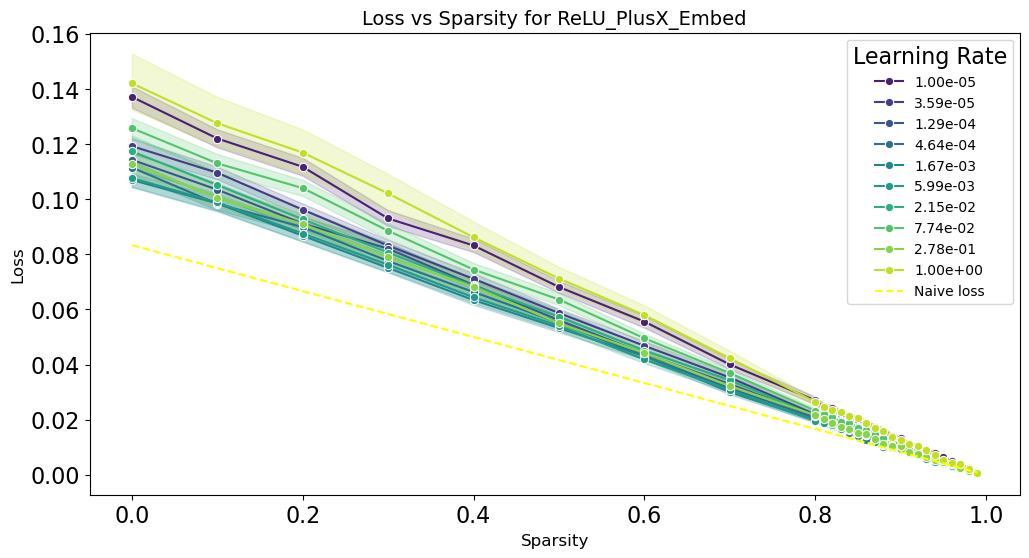

In [17]:
# Plot loss vs sparsity across learning rates

df = pd.DataFrame(loss_data)
loss =  np.array([0.5 * (1 - sparsities) / 6])
df["learning_rate_str"] = df["learning_rate"].apply(lambda x: f"{x:.2e}") 

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="sparsity", y="loss_per_feature", hue="learning_rate_str", marker="o", palette="viridis")
plt.plot(sparsities, loss.ravel(), linestyle="dashed", color="yellow", label=r"Naive loss")

# Labels & title
plt.xlabel("Sparsity", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss vs Sparsity for ReLU_PlusX_Embed", fontsize=14)
plt.legend(title="Learning Rate", fontsize=10)


# Show the plot
plt.show()

In [13]:
# Print out performance at sparsity = 0.99 and naive loss

# Set specific sparsity value
sparsity_value = 0.99

# Compute mean loss grouped by learning rate for the given sparsity
mean_losses = df[df["sparsity"] == sparsity_value].groupby("learning_rate")["loss_per_feature"].mean()

# Print results
for lr, mean_loss in mean_losses.items():
    print(f"Learning rate: {lr}, Mean loss for sparsity {sparsity_value}: {mean_loss:.4f}")

print("naive loss at S=0.99 is ", 0.5 * 0.01/6)

Learning rate: 9.999999999999999e-06, Mean loss for sparsity 0.99: 0.0012
Learning rate: 3.5938136638046256e-05, Mean loss for sparsity 0.99: 0.0008
Learning rate: 0.0001291549665014884, Mean loss for sparsity 0.99: 0.0006
Learning rate: 0.0004641588833612782, Mean loss for sparsity 0.99: 0.0005
Learning rate: 0.001668100537200059, Mean loss for sparsity 0.99: 0.0006
Learning rate: 0.005994842503189409, Mean loss for sparsity 0.99: 0.0005
Learning rate: 0.021544346900318843, Mean loss for sparsity 0.99: 0.0007
Learning rate: 0.07742636826811278, Mean loss for sparsity 0.99: 0.0007
Learning rate: 0.2782559402207126, Mean loss for sparsity 0.99: 0.0009
Learning rate: 1.0, Mean loss for sparsity 0.99: 0.0008
naive loss at S=0.99 is  0.0008333333333333334


In [ ]:
"""Create and train model. - Apollo's learning rate"""

def train_with_AdamW(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    optimizer = t.optim.AdamW(Cis.parameters(), lr=current_lr, weight_decay=0.01)
    
    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
         # Add this block to update the learning rate
        current_lr = config.lr * lr_schedule_fn(step, config.steps)
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses
    
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

# for training model
batch_sz = 2048
feat_sparsity = 0.99
feat_importance = 1
n_steps = 5000
logging_freq = n_steps // 10

# for testing over sparsities
sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
loss_data = []  # will store mean loss data
lr = 0.003

    
reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)
     

    
losses = train_with_AdamW(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        logging_freq
)
display(losses)

"""Get loss at inference over varying sparsity levels."""
    
pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 200
loss_data_reluPlusEmbedv1 = []
for s in pbar:
        
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(reluPlusX_res_embed_cis, n_examples, s)
                
                # compute mean loss
        y = reluPlusX_res_embed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
                
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
        loss_data.append({"learning_rate": lr, "sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})